In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

2023-02-22 21:33:59.856106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data set: 
####   8 stocks, data recored for 896 days, 240 prices per stock (every 1 mins, 4 hours)

In [15]:
# Download the data set
!cp -r '/Users/luluxu/Desktop/Math6373/HW/Homework_1/HW1_DATAuse' ./

In [16]:
import pandas as pd

A = list()
# Read the data set
for k in range(1,9):
  df = pd.read_csv(f'./HW1_DATAuse/{k}th_stock.csv',header=None)
  # 240 minutes per day, 896 days
  x = df.values
  A.append(x) 
  # Aj(t) the sequence of day t prices record every 1 min for  asset Aj
  

In [17]:
len(A), A[0].shape # 8 assets

(8, (240, 896))

In [18]:
# Check missing data
A = np.array(A)
A[np.isnan(A)].shape[0] / A.size

0.024072265625

In [19]:
# Clean data (nan)
# fill missing values with nearest element in the same row
for i in range(A.shape[0]):
    mask = np.isnan(A[i])
    if mask.any():
        A[i][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), A[i, ~mask])

In [20]:
# Check the rate of missing data
A = np.array(A) 
A[np.isnan(A)].shape[0] / A.size, A.shape

(0.0, (8, 240, 896))

In [21]:
# The closing price of 8 stocks of 896 days
B = list()
for a in A:
  b = a[-1]
  B.append(b)
len(B), B[0].shape

(8, (896,))

### Question 0: Graphic displays

In [22]:
# Normalized values Bj = Bj(t)/Bj(1)
m=[0,1,2,4,7] # Select 5 stocks we want to predict B1~B5
nB = [B[k]/B[k][0] for k in m] # normalize B(k)
len(nB), nB[0].shape


(5, (896,))

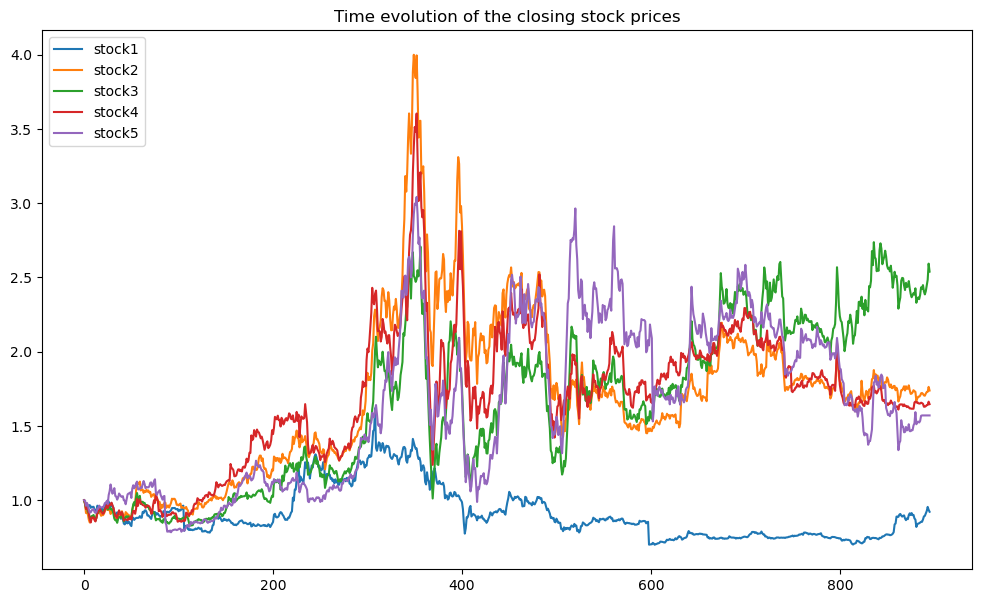

In [40]:
# Plot 5 curves displaying the time evolution of the five closing stock prices B1~B5
fig,ax=plt.subplots(figsize=(12,7))
for k in range(5):
  plt.plot(nB[k])
plt.title(f'Time evolution of the closing stock prices')
plt.legend(['stock1', 'stock2','stock3','stock4','stock5'], loc='upper left')

In [24]:
# Compute and display the 5*5 correlation matrix of B1,B2,B3,B4,B5
np.corrcoef(nB)

array([[ 1.        ,  0.31240122, -0.18457414,  0.17120125, -0.10941325],
       [ 0.31240122,  1.        ,  0.68229664,  0.9155472 ,  0.70554377],
       [-0.18457414,  0.68229664,  1.        ,  0.7543058 ,  0.76688439],
       [ 0.17120125,  0.9155472 ,  0.7543058 ,  1.        ,  0.82713106],
       [-0.10941325,  0.70554377,  0.76688439,  0.82713106,  1.        ]])

In [38]:
# Normalized values Aj = Aj(t)/Bj(1)
m=[0,1,2,4,7]
nA = [A[k][:,100]/B[k][0] for k in m]
len(nA), nA[0].shape


(5, (240,))

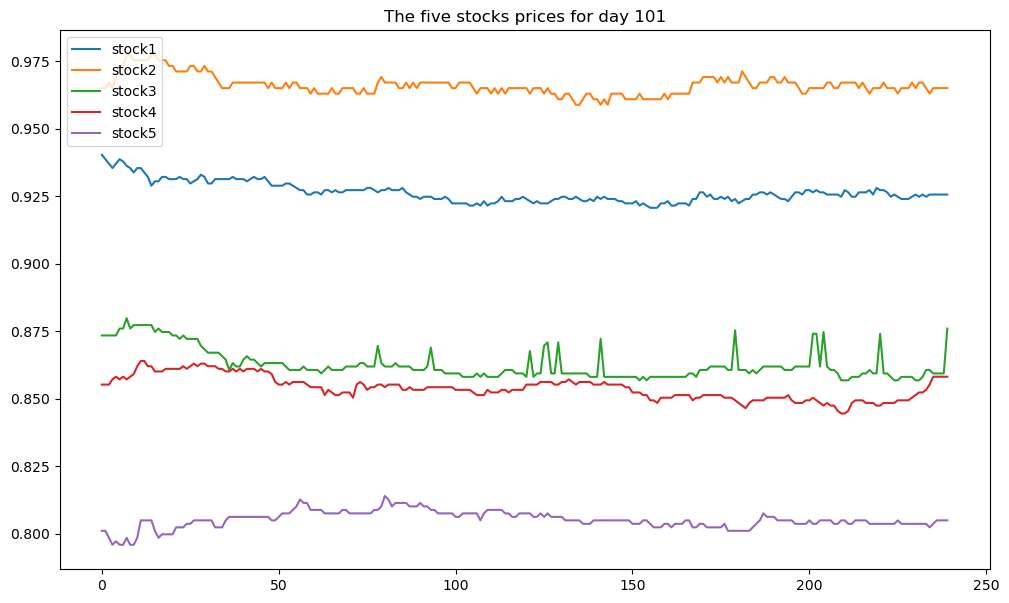

In [43]:
# Plot 5 curves displaying the time evolution of the five day t* prices A1~A5
fig,ax=plt.subplots(figsize=(12,7))
for k in range(5):
  plt.plot(nA[k])
plt.title(f'The five stocks prices for day 101')
plt.legend(['stock1', 'stock2','stock3','stock4','stock5'], loc='upper left')

### Question 1: PCA reduction of dimension for intraday data

In [44]:
A.shape

(8, 240, 896)

In [45]:
# Reshape  A to V, data V has 896 dimension and 1920 features.
V = A.transpose((2,0,1)) 
V = V.reshape(V.shape[0],-1)
V.shape

(896, 1920)

In [46]:
# Normalized data V
V1 = V - V.mean(axis=0, keepdims=True)
V11 = V1 / V1.std(axis=0, keepdims=True)

/Users/luluxu/opt/anaconda3/envs/math6373/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


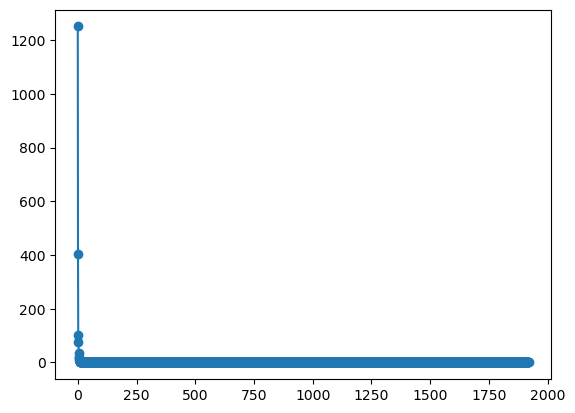

In [47]:
# Compute the correlation matrix VV of V11
# Display graphically its eigenvalues in decreasing order
VV = np.corrcoef(V11.T)
eigenvalues = np.linalg.eig(VV)
plt.plot(eigenvalues[0],'-o')

In [48]:
V.shape

(896, 1920)

In [49]:
# Implement PCA analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95) 
# Compute the smallest number K of principal components to explain 95% of the variance of V
U=pca.fit_transform(V) # Compute and denote U(t)
U.shape # Data U is 894 dimention and 4 features

(896, 4)

### Question 2: Single layer MLP architecture

In [50]:
# Select 5 stocks Y(t+1) to predict
m=[0,1,2,4,7]
y= [B[k] for k in m] 
len(y), y[0].shape

(5, (896,))

In [51]:
Y = np.array(y)
Y = Y.T 
Y.shape, U.shape

((896, 5), (896, 4))

In [52]:
N = Y.shape[0]
N

896

In [53]:
# Feature Vector X(t) = [U(t),U(t-1),U(t-2)], dim X(t) = 3*K
# MLP output = vector Y(t) = [B1(t+1),B2(t+1),B3(t+1),B4(t+1),B5(t+1)], dim Y(t)=5

# Split data to training data and test data
X_train = list()

for i in range(N-63): # Training set = first N-63 cases
  vector12 = [U[i], U[i+1], U[i+2]]
  vector12 = np.array(vector12).flatten()
  X_train.append(vector12)

X_train = np.array(X_train)
X_train.shape

(833, 12)

In [54]:
X_test = list() # Test set = last 60 cases

for i in range(N-63,N-3):
  vector12 = [U[i], U[i+1], U[i+2]]
  vector12 = np.array(vector12).flatten()
  X_test.append(vector12)

X_test = np.array(X_test)
X_test.shape

(60, 12)

In [55]:
Y_train = Y[3:N-60]
Y_train.shape

(833, 5)

In [56]:
Y_test = Y[N-60:]
Y_test.shape

(60, 5)

In [57]:
# Single layer MLP architecture: input layer L1, hidden layer L2, output layer L3
# L1 = 3*K, L2 = h, L3 = 5

In [58]:
# Denote w(h) the total number of weights and thresholds in the MLP
# w = (3*K)*h + h + h*5 + 5
# w = 18h + 5
# impose w < # informations brought by the training set
# 18h + 5 < 833*5
# H = 231

In [59]:
# Define the different sizes for the hidden layer
# hidden_layer_sizes: h1=H, h2=2H, h3=3H
# hidden_layer_sizes = [231, 462, 693]

### Question 3: Traning a single layer MLP

In [60]:
# hidden_layer_sizes = [h1=231, h2=462, h3=693]
# epoches = [e1=150, e2=250, e3=350]
# batch size = [m1=50, m2=30] (m1=50 there are 17 batches, m2=30 there are 28 batches)
# response function = RULU
# weights&threshold initialization = random
# gradient descent optimizer = Adam
# loss function = MSE

In [63]:
def Norm_grad_fn(grads): #define a normalize gradient function.
    w = grads[0].numpy().flatten()
    for i in range(1, 4):
        w2 = grads[i].numpy().flatten()
        w = np.append(w, w2)
    return np.linalg.norm(w)/np.sqrt(5*X_train.shape[0])

def module(epochs,batch_size,h): 
    Grad=list() #create list for outputs
    Norm_grad_byepoch=list()
    Norm_grad_bybatch=list()
    trainMSE=list()
    testMSE=list()
    prediction_train=list()
    prediction_test=list()

    model = tf.keras.Sequential() #build model
    model.add(keras.Input(shape=(12,)))
    model.add(layers.Dense(h, activation="relu"))
    model.add(layers.Dense(5,activation="relu"))
    model
    
    model.compile(optimizer='adam',
                  loss= tf.keras.losses.MeanSquaredError(),
                  metrics=['accuracy'])# Compile the model

    loss_fn = tf.keras.losses.MeanSquaredError() #define loss function

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)) # for batch train , create dataset
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(batch_size)

    start = time.time()
    for epoch in range(epochs):
        #print('\n start of epoch',epoch)
        for step, (Xbatch_train, Ybatch_train) in enumerate(train_dataset): # batch to batch ,gradient descent to minimize mse
            with tf.GradientTape() as tape:
                predictions_train = model(Xbatch_train, training=True)
                loss_train = loss_fn(Ybatch_train, predictions_train)

                grads = tape.gradient(loss_train, model.trainable_weights)
                model.optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

                Grad.append(grads)  #every gradients, grads is a list of len 4
                normlized_grad=Norm_grad_fn(grads)
                Norm_grad_bybatch.append(normlized_grad)

        #after batch to batch, calculate RMSE & gradient again (this time for entire training and test set) for each epoch
        prediction_train_epoch=model(X_train,training=False)
        prediction_test_epoch=model(X_test,training=False)
        
        prediction_train.append(prediction_train_epoch)
        prediction_test.append(prediction_test_epoch)

        loss_train = loss_fn(Y_train, prediction_train_epoch)
        trainMSE.append(loss_train.numpy())

        loss_test= loss_fn(Y_test,prediction_test_epoch)
        testMSE.append(loss_test.numpy())

        Norm_grad_byepoch.append(Norm_grad_fn(grads))
        #save model(use diff names )  model,epoch,
        #model.save('my_model',epoch)
    end=time.time()
    cpu=end-start
    return(cpu,model,trainMSE,testMSE,Norm_grad_byepoch,
           Norm_grad_bybatch,prediction_test,prediction_train)# function outputs


 epoch = 150 batch_size= 30 dense = 231
When k= 74
min_testRMSE= 1.181157
When k= 74 TrainMSE_k= 1.8859985


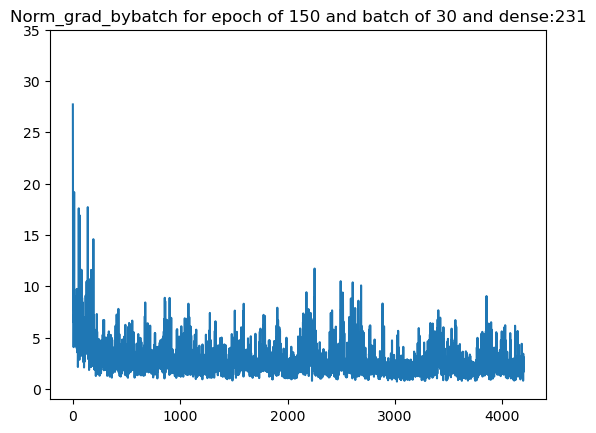

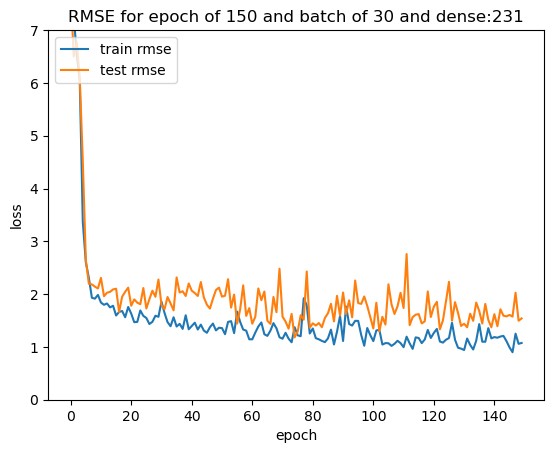


 epoch = 150 batch_size= 50 dense = 231
When k= 31
min_testRMSE= 1.8201159
When k= 31 TrainMSE_k= 2.582368


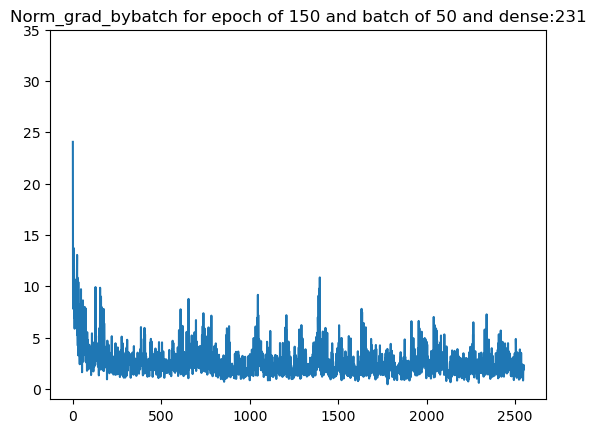

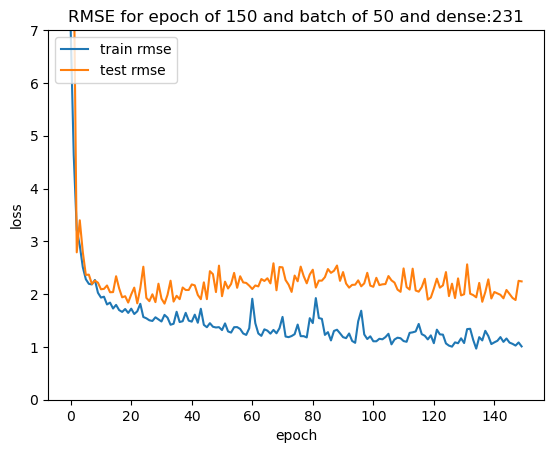


 epoch = 150 batch_size= 30 dense = 462
When k= 140
min_testRMSE= 1.5101045
When k= 140 TrainMSE_k= 1.0823296


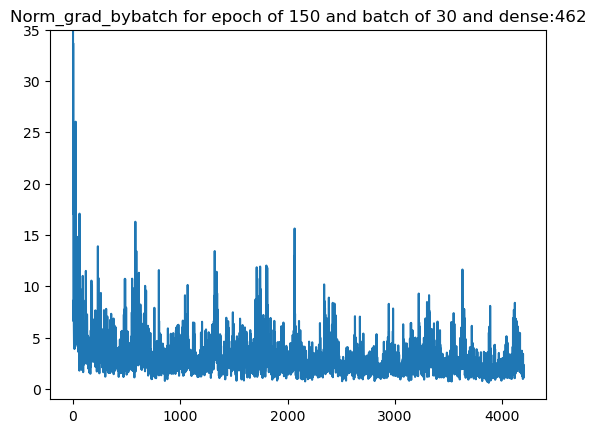

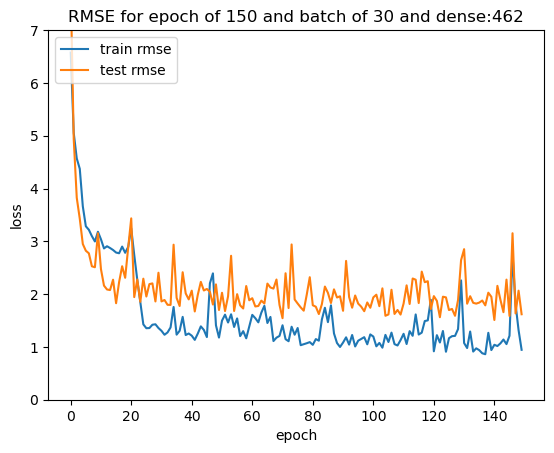


 epoch = 150 batch_size= 50 dense = 462
When k= 144
min_testRMSE= 1.2736834
When k= 144 TrainMSE_k= 1.1835457


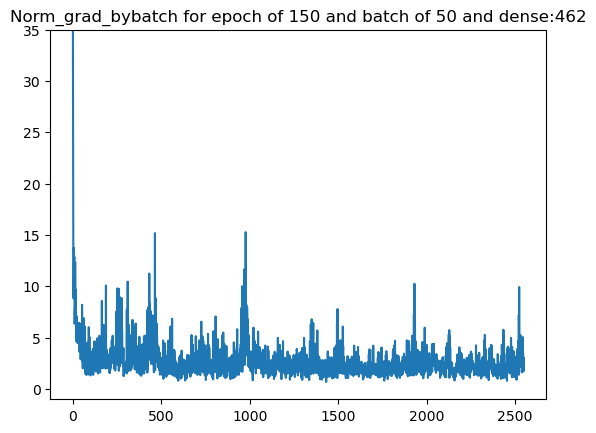

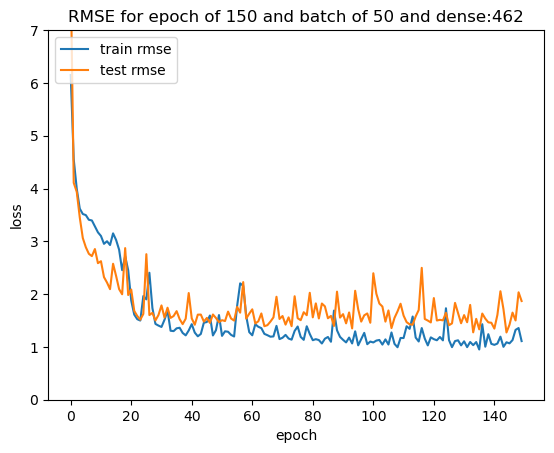


 epoch = 150 batch_size= 30 dense = 693
When k= 142
min_testRMSE= 1.2926077
When k= 142 TrainMSE_k= 1.9220854


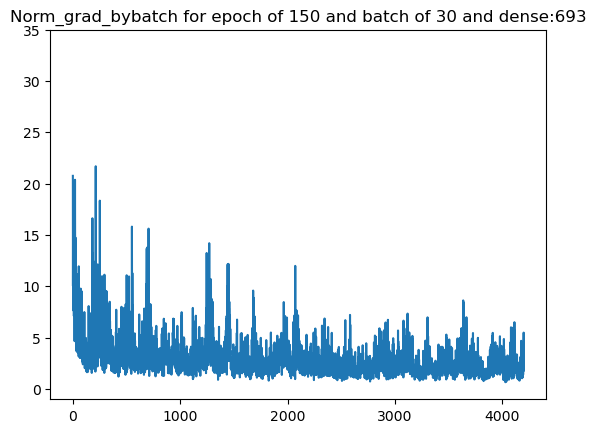

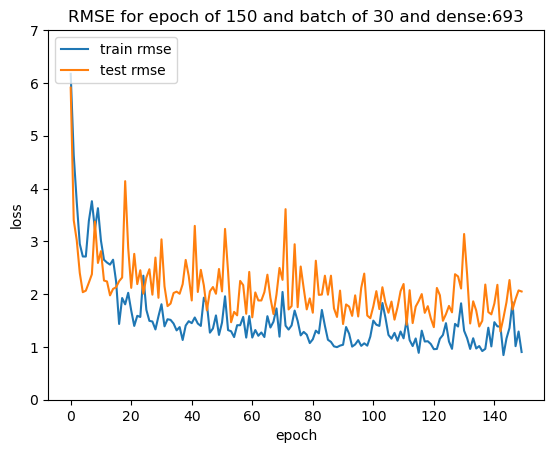


 epoch = 150 batch_size= 50 dense = 693
When k= 111
min_testRMSE= 1.1097742
When k= 111 TrainMSE_k= 1.2833701


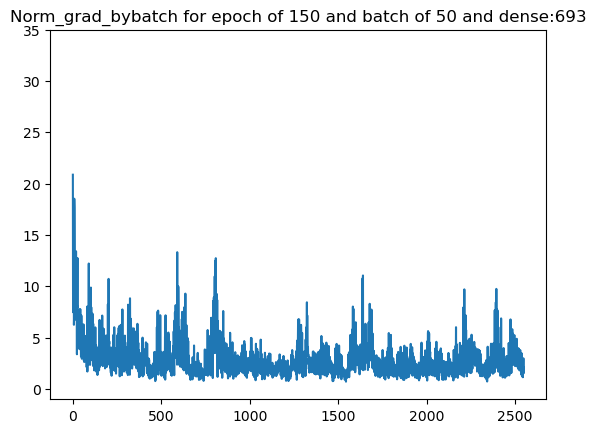

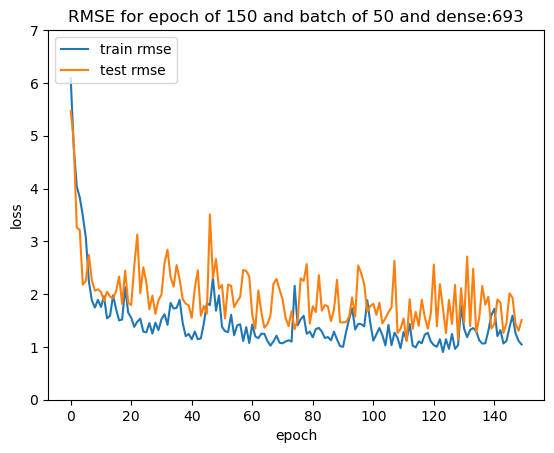


 epoch = 250 batch_size= 30 dense = 231
When k= 49
min_testRMSE= 1.2849388
When k= 49 TrainMSE_k= 3.083644


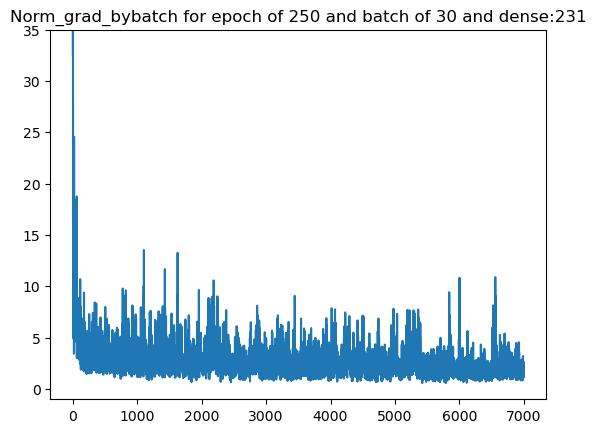

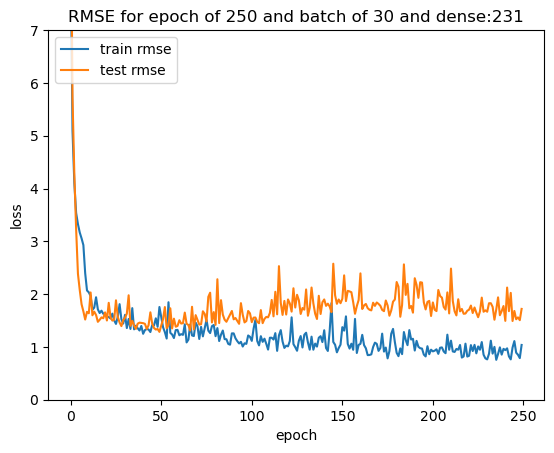


 epoch = 250 batch_size= 50 dense = 231
When k= 249
min_testRMSE= 1.9550678
When k= 249 TrainMSE_k= 1.1180869


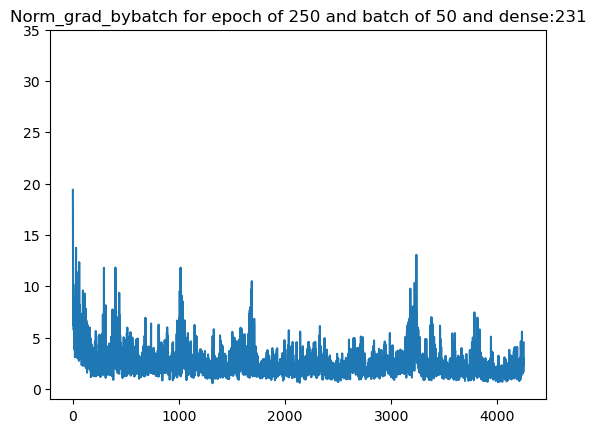

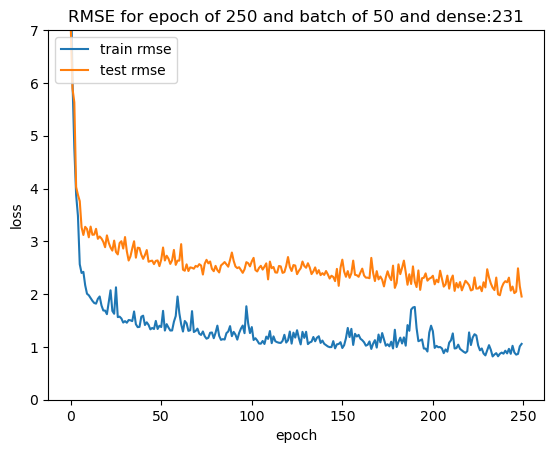


 epoch = 250 batch_size= 30 dense = 462
When k= 241
min_testRMSE= 4.6751146
When k= 241 TrainMSE_k= 26.555912


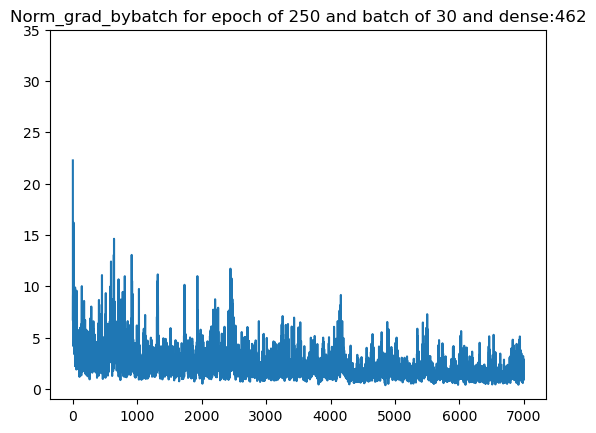

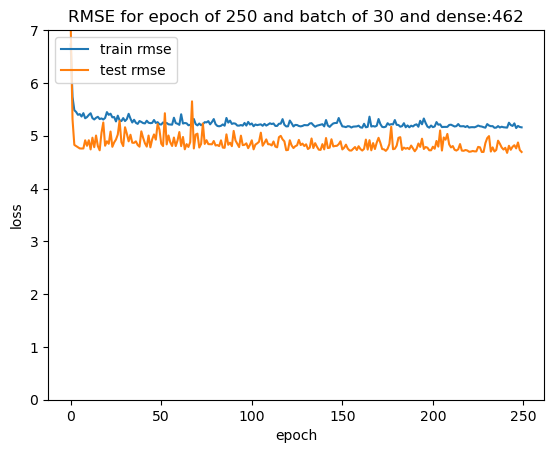


 epoch = 250 batch_size= 50 dense = 462
When k= 249
min_testRMSE= 1.3060753
When k= 249 TrainMSE_k= 1.1273757


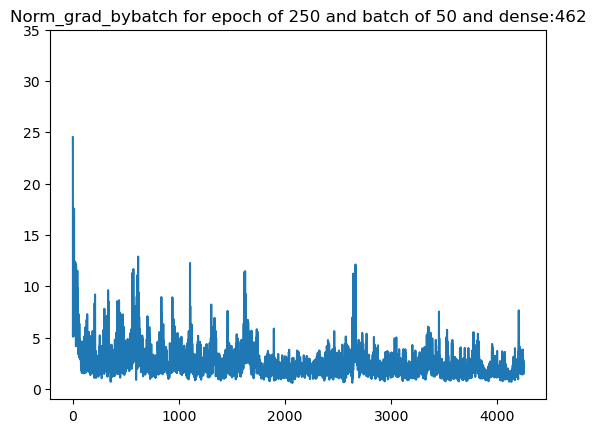

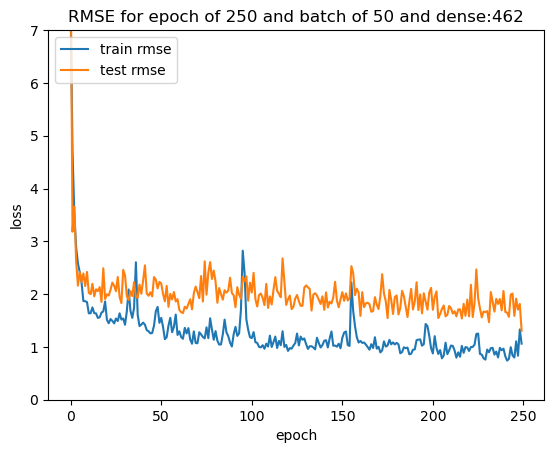


 epoch = 250 batch_size= 30 dense = 693
When k= 230
min_testRMSE= 1.0866314
When k= 230 TrainMSE_k= 0.64502984


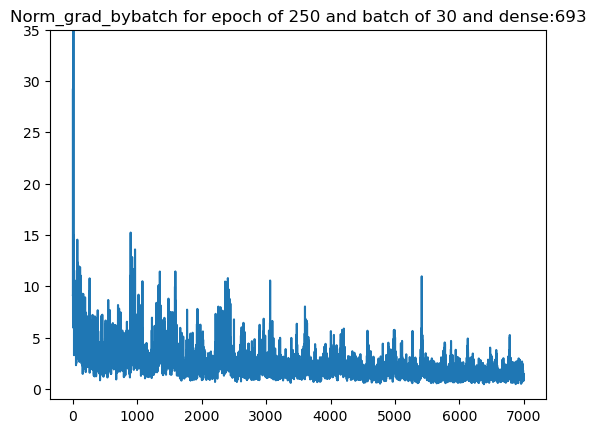

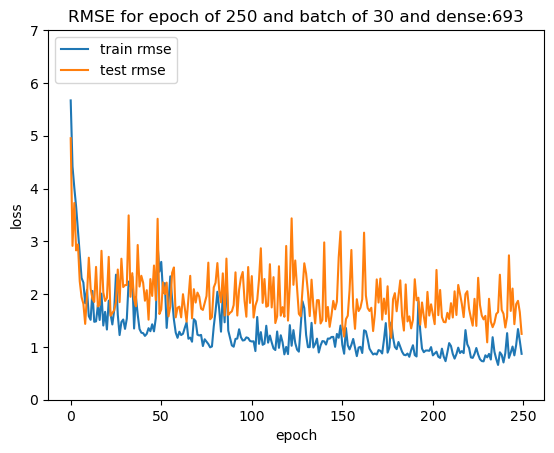


 epoch = 250 batch_size= 50 dense = 693
When k= 216
min_testRMSE= 1.1093795
When k= 216 TrainMSE_k= 0.76890016


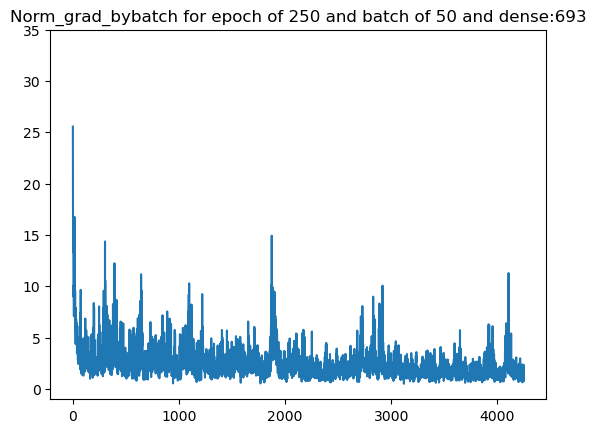

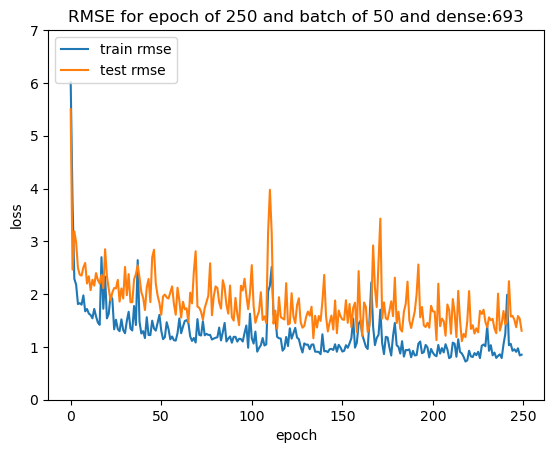

In [72]:
#pair of epoch,  h and m
# return(cpu,model,trainMSE,testMSE,Norm_grad_byepoch,Norm_grad_bybatch,#prediction)   # function outputs
epochs=[150,250]
batch_size=[30,50]
h_list=[231,462,693]


cpu_list=[]
nor_grad=[]
train_mse=[]
train_rmse=[]
test_mse=[]
test_rmse=[]
k_epoch=[]
min_testRMSE=[]
min_trainRMSE=[]
prediction_train=[]
prediction_test=[]
for e in epochs:
    for h in h_list:
        for m in batch_size:
            print('\n epoch =',e,'batch_size=',m,'dense =',h)
            model_results=module(e,m,h)

            cpu=model_results[0]
            cpu_list.append(round(cpu,4))

            Norm_grad_bybatch=model_results[5]
            nor_grad.append(Norm_grad_bybatch)


            TrainMSE=model_results[2]
            train_mse.append(TrainMSE)
            train_rmse.append(np.sqrt(TrainMSE))

            TestMSE=model_results[3]
            test_mse.append(TestMSE)
            TestRMSE= np.sqrt(TestMSE)
            test_rmse.append(TestRMSE.round(decimals=4))

            prediction_test = model_results[6]
            prediction_test.append(prediction_test)
            
            prediction_train = model_results[7]
            prediction_train.append(prediction_train)

            k=np.argmin(TestRMSE)
            k_epoch.append(k)
            print('When k=',k) 

            min_testRMSE_k=np.min(TestRMSE)
            print('min_testRMSE=', min_testRMSE_k)
            min_testRMSE.append(min_testRMSE_k)

            TrainMSE_k=model_results[2][k]
            print('When k=',k, 'TrainMSE_k=',TrainMSE_k)
            min_trainRMSE.append(TrainMSE_k)
            
           
             

            plt.plot(Norm_grad_bybatch)
            plt.title("Norm_grad_bybatch for epoch of {0} and batch of {1} and dense:{2}".format(e,m,h))
            plt.savefig("Norm_grad_bybatch for epoch of {0} and batch of {1} and dense:{2} h.jpg".format(e,m,h),dpi=400)
            plt.ylim(-1, 35)
            plt.show()

            plt.plot(np.sqrt(TrainMSE))
            plt.plot(np.sqrt(TestMSE))
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train rmse', 'test rmse'], loc='upper left')
            plt.title("RMSE for epoch of {0} and batch of {1} and dense:{2}".format(e,m,h))
            plt.savefig("RMSE for  epoch of {0} and batch of {1} and dense:{2} h.jpg".format(e,m,h),dpi=400)
            plt.ylim(0,7)
            plt.show()


In [73]:
results=pd.DataFrame({'dense(h)':[231,231,462,462,693,693,231,231,462,462,693,693],
                      'batches(m)':[30,50,30,50,30,50,30,50,30,50,30,50],                      
                      'epochs(e)':[150,150,150,150,150,150,250,250,250,250,250,250]
})
results['cpu_list']=cpu_list
results['k_epoch']=k_epoch
results['testRMSE_k']=min_testRMSE
results['trainRMSE_k']=min_trainRMSE
results

,dense(h),batches(m),epochs(e),cpu_list,k_epoch,testRMSE_k,trainRMSE_k
0,231,30,150,17.3413,74,1.181157,1.885998
1,231,50,150,10.8744,31,1.820116,2.582368
2,462,30,150,18.3398,140,1.510105,1.082330
3,462,50,150,11.5147,144,1.273683,1.183546
4,693,30,150,18.8977,142,1.292608,1.922085
5,693,50,150,12.7129,111,1.109774,1.283370
6,231,30,250,28.5918,49,1.284939,3.083644
7,231,50,250,18.0413,249,1.955068,1.118087
8,462,30,250,30.1521,241,4.675115,26.555912
9,462,50,250,19.0632,249,1.306075,1.127376


In [ ]:
# The best pair(h,m) among the six(hi,mj) is h=462, m=50, epoch=150.
# The MLP* Iis the best "one hidden layer" MLP(h=462, m=50, e=150)

### Question 4: Practical evaluation of your best "one hidden layer" MLP*

In [140]:
# Apply the best "one hidden layer" MLP*
results_star=module(150,50,693)

In [230]:
# DenoteZ(t), the output computed by MLP*
prediction_test=results_star[6] #prediction result of test set
prediction_train=results_star[7]

Zt_test=prediction_test[-1]
Zt_train=prediction_train[-1]

In [231]:
# Compute the 5 Relative Error of Prediction REPj(t)=|Zj(t)-Bj(t+1)|/Bj(t+1) for all test cases
# REP for test set 
REP= abs(Zt_test-Y_test)/Y_test*100
REP=np.round(REP,2)
np.set_printoptions(suppress=True)
REP.shape

(60, 5)

In [232]:
# REP for train set 
REP_train= abs(Zt_train-Y_train)/Y_train*100
REP_train=np.round(REP_train,2)
np.set_printoptions(suppress=True)
REP_train.shape

(833, 5)

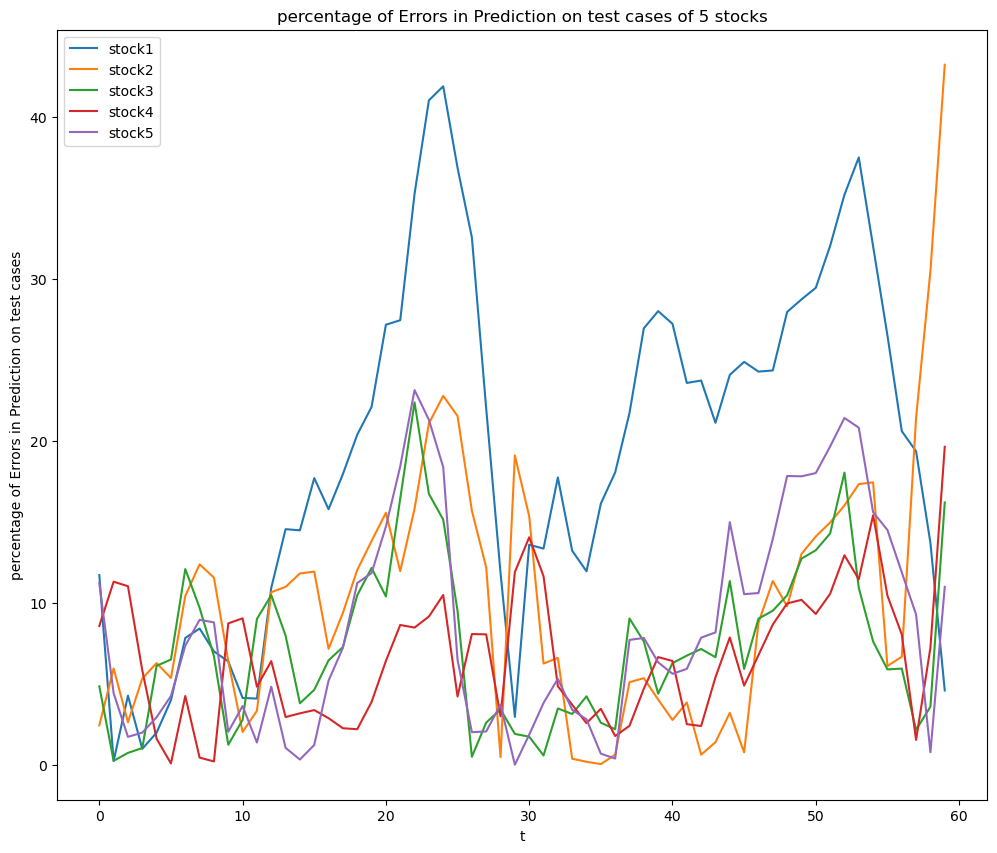

In [233]:
# Display these 5 curves REPj(t) versus t on test cases
fig,ax=plt.subplots(figsize=(12,10))
for i in range(5):
    plt.plot(REP[:,i])
plt.ylabel('percentage of Errors in Prediction on test cases')
plt.xlabel('t')
plt.legend(['stock1', 'stock2','stock3','stock4','stock5'], loc='upper left')
plt.title("percentage of Errors in Prediction on test cases of 5 stocks")
plt.savefig("percentage of Errors in Prediction on test cases of 5 stocks",dpi=400)
plt.show()     

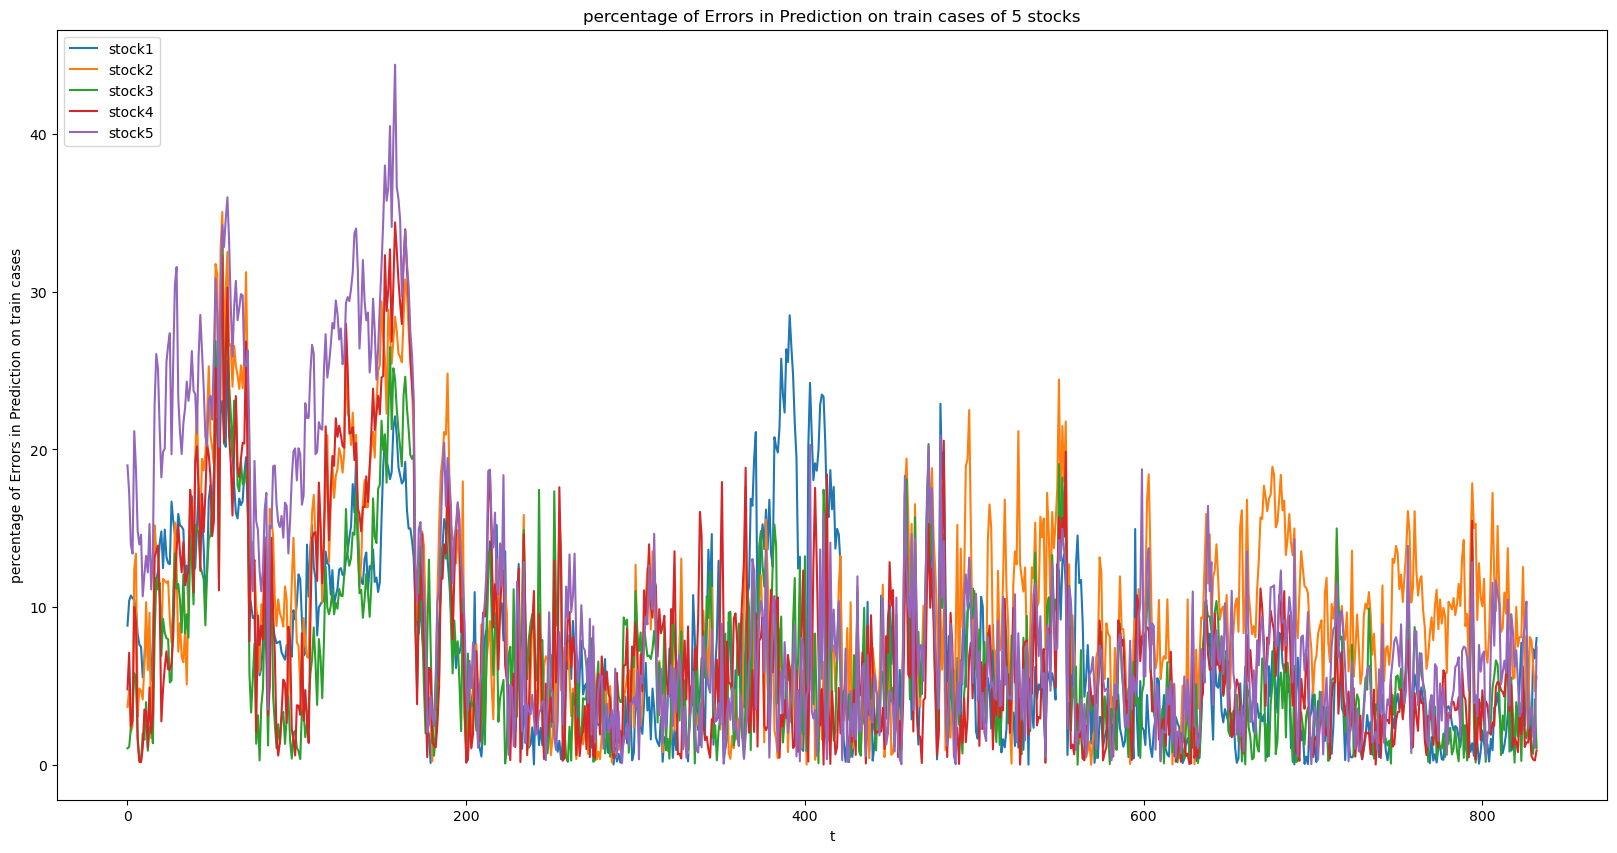

In [234]:
# Display these 5 curves REPj(t) versus t on training cases
fig,ax=plt.subplots(figsize=(20,10))
for i in range(5):
    plt.plot(REP_train[:,i])
plt.ylabel('percentage of Errors in Prediction on train cases')
plt.xlabel('t')
plt.legend(['stock1', 'stock2','stock3','stock4','stock5'], loc='upper left')
plt.title("percentage of Errors in Prediction on train cases of 5 stocks")
plt.savefig("percentage of Errors in Prediction on train cases of 5 stocks",dpi=400)
plt.show()

In [235]:
# Sort the array by columns
b = np.sort(REP, axis=0)

In [281]:
# The 6 highest REPj(t) and the 6 lowest REPj(t)
high_REP = b[-6:,:]
low_REP = b[0:6,:]

high_REP

array([[20.69, 16.36, 12.96, 21.76, 13.77],
       [21.26, 17.2 , 13.81, 21.98, 13.9 ],
       [21.46, 18.31, 15.4 , 22.41, 15.15],
       [22.11, 19.19, 15.52, 23.28, 15.36],
       [22.74, 24.98, 16.14, 28.55, 21.9 ],
       [25.  , 36.88, 18.13, 40.99, 22.9 ]], dtype=float32)

In [282]:
low_REP

array([[0.54, 0.5 , 0.37, 0.28, 0.11],
       [0.66, 0.89, 0.44, 0.73, 0.19],
       [1.24, 1.05, 0.49, 0.75, 0.5 ],
       [1.26, 1.13, 0.59, 1.09, 0.6 ],
       [1.26, 1.43, 1.  , 1.09, 0.67],
       [1.29, 1.43, 1.12, 1.63, 0.74]], dtype=float32)

In [283]:
# Compute median medREPj = 60%REPj(t), for each stock Aj, j=1,2,3,4,5
# Calculate the index of the 60th percentile
med_REPj = list()
for i in range(5):
    index = int(len(b[:,i]) * 0.6)
    # Select the top 60% of values
    subset = b[index,i]
    med_REPj.append(subset)
med_REPj

[9.6, 8.76, 7.44, 13.0, 7.73]

In [239]:
# Compare the REPj(t) on 3 time periods[N-60,...N-41],[N-40,...,N-21],[N-20,...,N-1]
REP_1 = REP[0:20]
REP_2 = REP[20:40]
REP_3 = REP[40:59]
REP_1.shape,REP_2.shape,REP_3.shape

((20, 5), (20, 5), (19, 5))

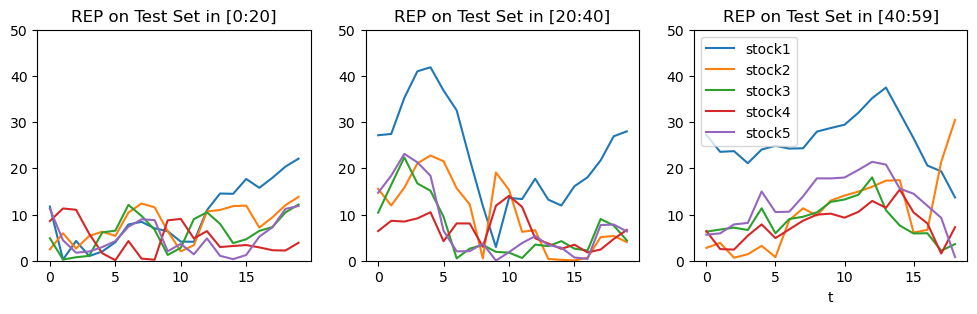

In [240]:
# Display these 5 curves REPj(t) versus t on test cases
fig,ax=plt.subplots(1,3,figsize=(12,3))
ax[0].plot(REP_1)
ax[0].set_title('REP on Test Set in [0:20]' )
ax[0].set_ylim(0,50)
ax[1].plot(REP_2)
ax[1].set_title('REP on Test Set in [20:40]' )
ax[1].set_ylim(0,50)
ax[2].plot(REP_3)
ax[2].set_title('REP on Test Set in [40:59]' )
ax[2].set_ylim(0,50)
plt.xlabel('t')
plt.legend(['stock1', 'stock2','stock3','stock4','stock5'], loc='upper left')
plt.savefig("REP on test cases of 5 stocks in 3 diffrent preiord",dpi=400)
plt.show()     

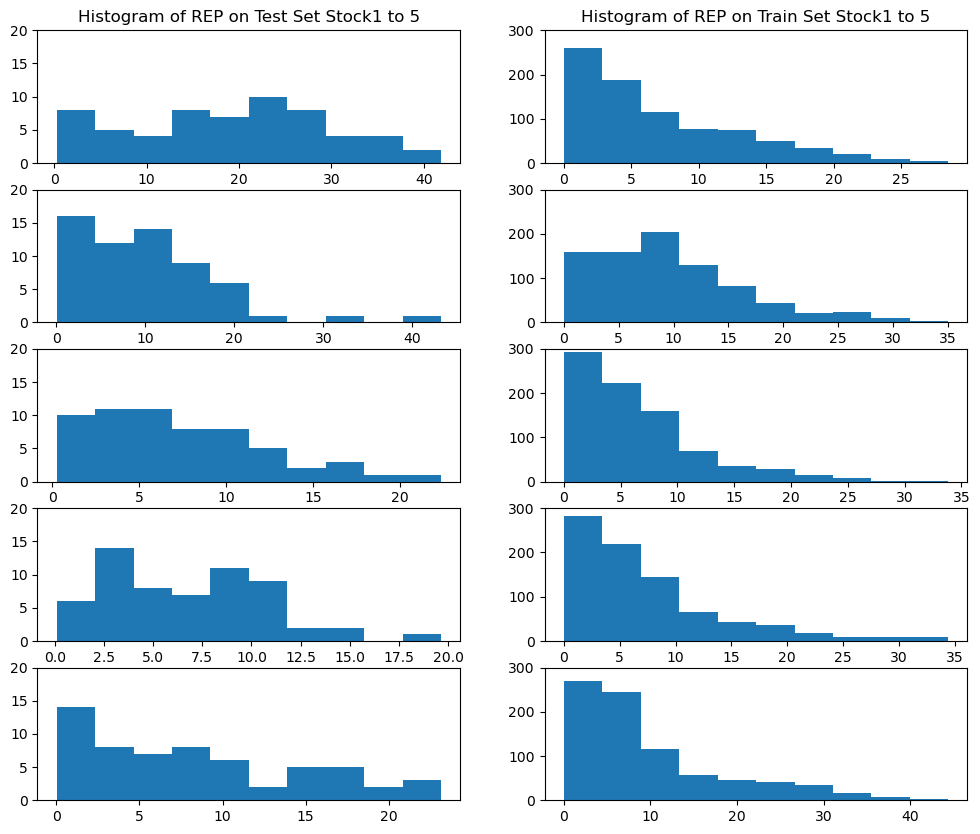

In [242]:
# add histogram for test set and train set 
#plot 5 by 2 
fig,ax=plt.subplots(5,2,figsize=(12,10))
for i in range(5):
    ax[i,0].hist(REP[:,i])
    ax[0,0].set_title('Histogram of REP on Test Set Stock1 to 5' )
    ax[i,0].set_ylim(0,20)
    ax[i,1].hist(REP_train[:,i])
    ax[0,1].set_title('Histogram of REP on Train Set Stock1 to 5' )
    ax[i,1].set_ylim(0,300)
plt.show()

In [243]:
# Compute the 5 true rate of return TRRj(t)=|Bj(t)-Bj(t+1)|/Bj(t+1) for t=N-60,...,N-1
TRR_j = list()
for j in range(5):
   for i in range(59):
      TRR = abs(Y_test[i,j]-Y_test[i+1,j])/Y_test[i+1,j]*100     
      TRR_j.append(TRR)
len(TRR_j),TRR_j[0].shape

(295, ())

In [244]:
TRRj=np.reshape(TRR_j,(5,59)).T
TRRj.shape

(59, 5)

In [245]:
# Evaluate the ratios Sj(t)=REPj(t)/TRRj(t) for t=N-60,...,N-1 for each stock
Sj = REP[:59]/TRRj
Sj.shape

/var/folders/qf/45vdh7_x3tn8ms40l6dgzrbh0000gn/T/ipykernel_40494/1927147162.py:2: RuntimeWarning: divide by zero encountered in divide
  Sj = REP[:59]/TRRj


(59, 5)

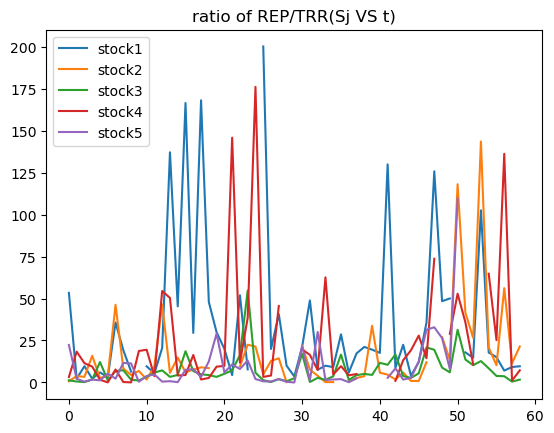

In [246]:
# Plot these 5 ratios versus t
plt.plot(Sj)
plt.title("ratio of REP/TRR(Sj VS t)") 
plt.legend(['stock1', 'stock2','stock3','stock4','stock5'], loc='upper left')

In [247]:
# medSj = median(all Sj(t))preferable to mean
# Sort the array by columns
bs = np.sort(Sj, axis=0)
medSj= list()
for i in range(5):
    index = int(len(bs[:,i]) * 0.6)
    # Select the top 50% of values
    subset = bs[index,i]
    medSj.append(subset)
np.round(medSj,4)

array([22.4399, 13.6059,  5.9016, 19.6817, 11.344 ])

In [152]:
# On day t , prediction Zj(t) for  the future closing price Bj(t+1) for stock #j
# Compute  predSIGNj(t) = sign [ Zj(t) – Bj(t) ] (equals  either +1 or -1)
# This predicts whether stockprice  # j will increase or decrease on day  t+1
# Compute  trueSIGNj(t) = sign [ Bj(t+1) – Bj(t) ]
# Correct Sign Prediction[CSP] : if predSIGNj(t) = trueSIGNj(t) 

In [156]:
# CSP FOR test set
predSIGN=np.sign(Zt_test-Y_test)  # contains only 1 or -1
trueSIGN_list=[]  # contains 0,1,-1
for s in range(5):
    for i in range(59):
        TRR_SIGN=np.sign(Y_test[i+1,s]-Y_test[i,s])
        trueSIGN_list.append(TRR_SIGN)
trueSIGN=np.reshape(trueSIGN_list,(5,59)).T
sign_subtract=trueSIGN-predSIGN[0:59,:]  #subtraction 2 array, if result is 0, prediction correctly. 
unique,counts = np.unique(sign_subtract, return_counts=True) # counts[2]is the count of '0'
CSP_test=counts[2]/(59*5) # percentage of correct sign prediction on test set
CSP_test

0.4271186440677966

In [157]:
# Compare CSP_test for each stocks
for i in range(5):
    unique,counts= np.unique(sign_subtract[:,i], return_counts=True)
    CSP_test_stock=counts[unique==0]/59
    print('CSP_test_stock',i+1,CSP_test_stock)

CSP_test_stock 1 [0.3220339]
CSP_test_stock 2 [0.45762712]
CSP_test_stock 3 [0.50847458]
CSP_test_stock 4 [0.44067797]
CSP_test_stock 5 [0.40677966]


In [158]:
# CSP For train set
predSIGN_train=np.sign(Zt_train-Y_train)  #shape 833 by 5 
trueSIGN_train_list=[]# shape 832 by 5 
for s in range(5):
    for i in range(832):
        TRU_SIGN_TRAIN=np.sign(Y_train[i+1,s]-Y_train[i,s])
        trueSIGN_train_list.append(TRU_SIGN_TRAIN)
trueSIGN_train=np.reshape(trueSIGN_train_list,(5,832)).T  
sign_subtract_train=trueSIGN_train-predSIGN_train[0:832,:]  #subtraction 2 array, if result is 0, prediction correctly. 
unique1,counts1 = np.unique(sign_subtract_train, return_counts=True) # counts[2]is the count of '0'
CSP_train=counts1[2]/(832*5) # percentage of correct sign prediction on train set
CSP_train

0.49278846153846156

In [159]:
# Compare CSP_train for each stocks
for i in range(5):
    unique,counts= np.unique(sign_subtract_train[:,i], return_counts=True)
    CSP_train_stock=counts[unique==0]/832
    print('CSP_train_stock',i+1,CSP_train_stock)

CSP_train_stock 1 [0.49158654]
CSP_train_stock 2 [0.47115385]
CSP_train_stock 3 [0.51802885]
CSP_train_stock 4 [0.50721154]
CSP_train_stock 5 [0.47596154]


### Question 5: PCA analysis of layer L2 in MLP*

In [92]:
# The layer L2 in MLP* has dimension h*=693
# Z1 = X
# Z2 = f(W2*Z1(t)+THR2)

In [101]:
# Compute all the vectors Z2(t),t=3,4,...,N.
X = np.concatenate((X_train, X_test), axis=0)
tfX = tf.constant(X, dtype = tf.float32)
W2 = tf.random.normal((12,693))
THR2 = tf.random.normal((1,693))

z2 = (tfX@W2) + THR2
Z2 = tf.keras.activations.relu(z2)

In [102]:
# Compute Z2 h* X h* correlation matrix M
Z2 = np.array(Z2)
M = np.corrcoef(Z2.T)
M.shape

(693, 693)

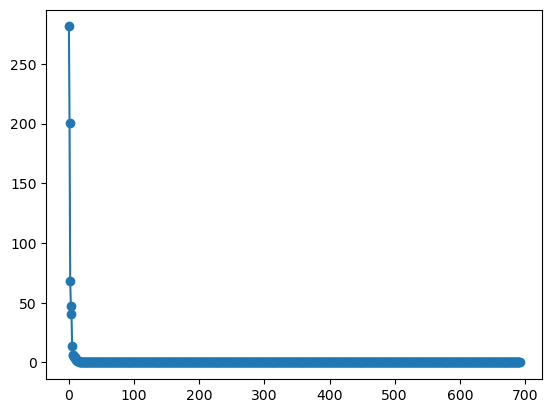

In [103]:
eigenvalues = np.linalg.eig(M)
Lm = eigenvalues[0]
plt.plot(Lm,'-o')

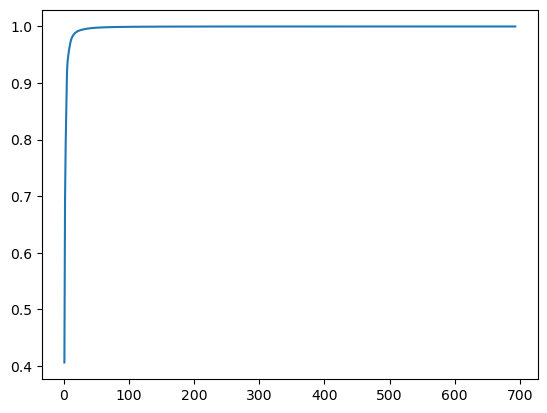

In [104]:
PEV=np.cumsum(Lm/sum(Lm))
plt.plot(range(1,694),PEV)

In [106]:
# Compute the smallest interger 'r', when PEV(r)>=90%
i=0
while i<=693:
  PEV = sum(Lm[0:i])/693
  if PEV >= 0.9:
    r = i
    break
  
  i = i+1

print('The smallest integer r*  such that PEV(r)>=90% is: ',r)

The smallest integer r*  such that PEV(r)>=90% is:  5


### Question 6: new MLP** with two hidden layers

In [107]:
def Norm_grad_fn(grads): #define a normalize gradient function.
    w = grads[0].numpy().flatten()
    for i in range(1, 4):
        w2 = grads[i].numpy().flatten()
        w = np.append(w, w2)
    return np.linalg.norm(w)/np.sqrt(5*X_train.shape[0])

def module2(epochs,batch_size,h): 
    Grad=list() #create list for outputs
    Norm_grad_byepoch=list()
    Norm_grad_bybatch=list()
    trainMSE=list()
    testMSE=list()
    prediction_test=list()

    model = tf.keras.Sequential() #build model
    model.add(keras.Input(shape=(12,)))
    model.add(layers.Dense(h, activation="relu"))
    model.add(layers.Dense(5, activation="relu"))
    model.add(layers.Dense(5,activation="relu"))
    model
    
    model.compile(optimizer='adam',loss= tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])# Compile the model

    loss_fn = tf.keras.losses.MeanSquaredError() #define loss function

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)) # for batch train , create dataset
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(batch_size)

    start = time.time()
    for epoch in range(epochs):
        #print('\n start of epoch',epoch)
        for step, (Xbatch_train, Ybatch_train) in enumerate(train_dataset): # batch to batch ,gradient descent to minimize mse
            with tf.GradientTape() as tape:
                predictions_train = model(Xbatch_train, training=True)
                loss_train = loss_fn(Ybatch_train, predictions_train)

                grads = tape.gradient(loss_train, model.trainable_weights)
                model.optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

                Grad.append(grads)  #every gradients, grads is a list of len 4
                normlized_grad=Norm_grad_fn(grads)
                Norm_grad_bybatch.append(normlized_grad)

        #after batch to batch, calculate RMSE & gradient again (this time for entire training and test set) for each epoch
        prediction_train_epoch=model(X_train,training=False)
        prediction_test_epoch=model(X_test,training=False)

        prediction_test.append(prediction_test_epoch)

        loss_train = loss_fn(Y_train, prediction_train_epoch)
        trainMSE.append(loss_train.numpy())

        loss_test= loss_fn(Y_test,prediction_test_epoch)
        testMSE.append(loss_test.numpy())

        Norm_grad_byepoch.append(Norm_grad_fn(grads))
        
    end=time.time()
    cpu=end-start
    return(cpu,model,trainMSE,testMSE,Norm_grad_byepoch,Norm_grad_bybatch, prediction_test)


 epoch = 150 batch_size=50, L2=693
When k= 144
min_testRMSE2= 1.4653646
When k= 144 TrainMSE_k= 1.8263298


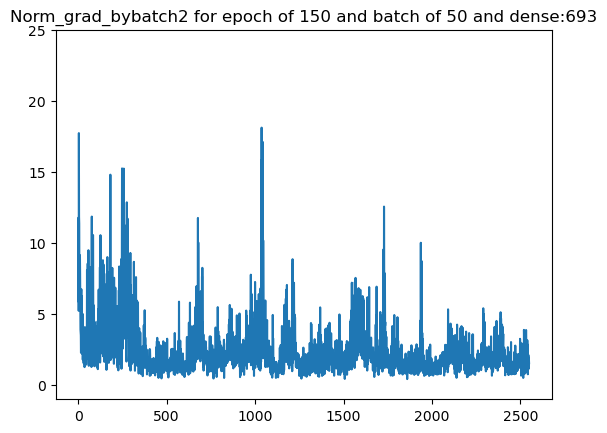

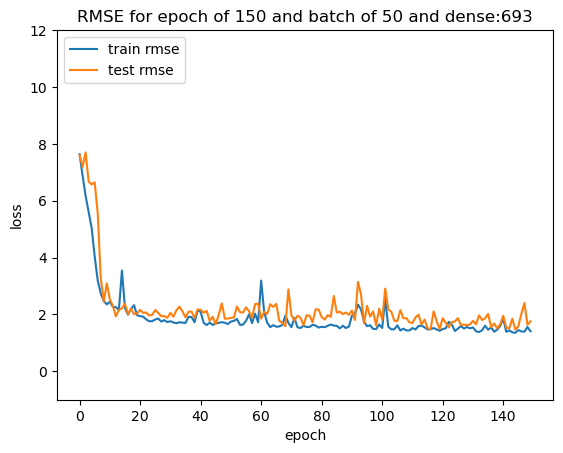


 epoch = 250 batch_size=50, L2=693
When k= 96
min_testRMSE2= 1.1864704
When k= 96 TrainMSE_k= 1.2459135


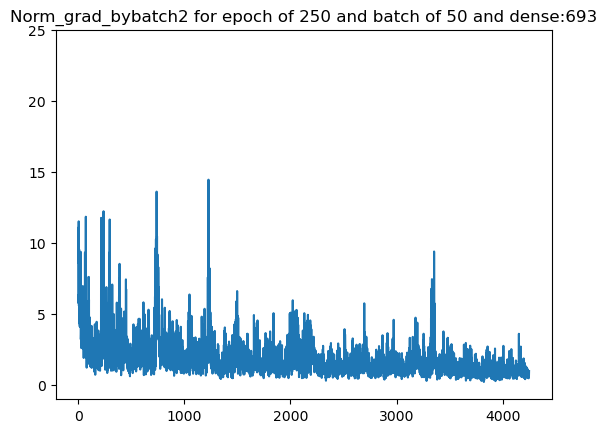

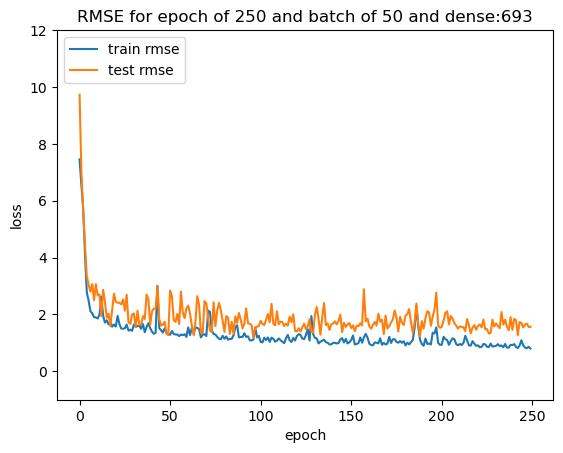


 epoch = 350 batch_size=50, L2=693
When k= 338
min_testRMSE2= 4.820802
When k= 338 TrainMSE_k= 18.370867


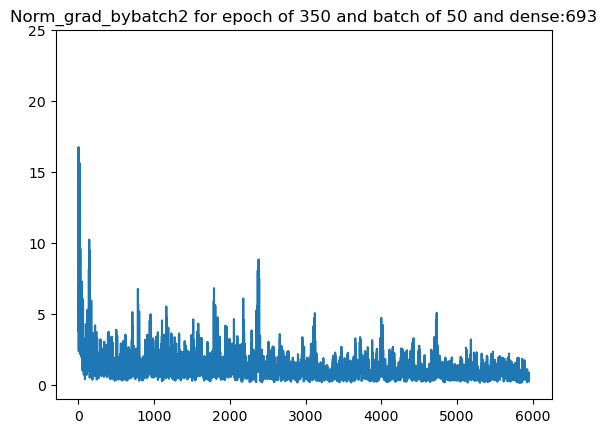

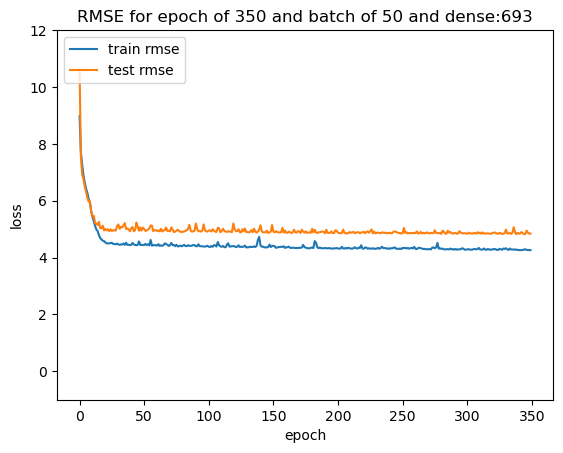

In [126]:
epochs=[150,250,350]


cpu_list2=[]
nor_grad2=[]
train_mse2=[]
train_rmse2=[]
test_mse2=[]
test_rmse2=[]
k_epoch2=[]
min_testRMSE2=[]
min_trainRMSE2=[]
prediction_test2=[]
for e in epochs:    
            print('\n epoch =',e,'batch_size=50, L2=693')
            model_results2=module2(e,50,693)

            cpu2=model_results2[0]
            cpu_list2.append(round(cpu2,4))

            Norm_grad_bybatch2=model_results2[5]
            nor_grad2.append(Norm_grad_bybatch2)


            TrainMSE2=model_results2[2]
            train_mse2.append(TrainMSE2)
            train_rmse2.append(np.sqrt(TrainMSE2))

            TestMSE2=model_results2[3]
            test_mse2.append(TestMSE2)
            TestRMSE2= np.sqrt(TestMSE2)
            test_rmse2.append(TestRMSE2.round(decimals=4))

            prediction_test2 = model_results2[6]
            prediction_test2.append(prediction_test2)

            k2=np.argmin(TestRMSE2)
            k_epoch2.append(k2)
            print('When k=',k2) 

            min_testRMSE_k2=np.min(TestRMSE2)
            print('min_testRMSE2=', min_testRMSE_k2)
            min_testRMSE2.append(min_testRMSE_k2)

            TrainMSE_k2=model_results2[2][k2]
            print('When k=',k2, 'TrainMSE_k=',TrainMSE_k2)
            min_trainRMSE2.append(TrainMSE_k2)
            
           
             

            plt.plot(Norm_grad_bybatch2)
            plt.title("Norm_grad_bybatch2 for epoch of {0} and batch of {1} and dense:{2}".format(e,50,693))
            plt.savefig("Norm_grad_bybatch2 for epoch of {0} and batch of {1} and dense:{2} h.jpg".format(e,50,693),dpi=400)
            plt.ylim(-1, 25)
            plt.show()

            plt.plot(np.sqrt(TrainMSE2))
            plt.plot(np.sqrt(TestMSE2))
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train rmse', 'test rmse'], loc='upper left')
            plt.title("RMSE for epoch of {0} and batch of {1} and dense:{2}".format(e,50,693))
            plt.savefig("RMSE for  epoch of {0} and batch of {1} and dense:{2} h.jpg".format(e,50,693),dpi=400)
            plt.ylim(-1, 12)
            plt.show()


In [127]:
results2=pd.DataFrame({'dense(h*)':[693,693,693],
                      'batches(m*)':[50,50,50],                      
                      'epochs(e)':[150,250,350]
})
results2['cpu_list']=cpu_list2
results2['k_epoch']=k_epoch2
results2['testRMSE_k']=min_testRMSE2
results2['trainRMSE_k']=min_trainRMSE2
results2

,dense(h*),batches(m*),epochs(e),cpu_list,k_epoch,testRMSE_k,trainRMSE_k
0,693,50,150,13.9889,144,1.465365,1.826330
1,693,50,250,23.2998,96,1.186470,1.245914
2,693,50,350,32.9526,338,4.820802,18.370867


### Question 7: Performance of MLP** with two hidden layers

In [257]:
# Apply the best "two hidden layer" MLP**
model_results_2=module2(150,50,693)


In [258]:
# DenoteZ(t), the output computed by MLP**
prediction_test_2 = model_results_2[6]
Z_2 = prediction_test_2[-1]
Z_2.shape

TensorShape([60, 5])

In [286]:
# Compute the 5 Relative Error of Prediction REPj(t)=|Zj(t)-Bj(t)|/Bj(t+1) for all test cases
REPj_2 = abs(Z_2 - Y_test)/Y_test*100
REPj_2 = np.array(REPj_2)
REPj_2 = np.round(REPj_2,2)
np.set_printoptions(suppress=True)


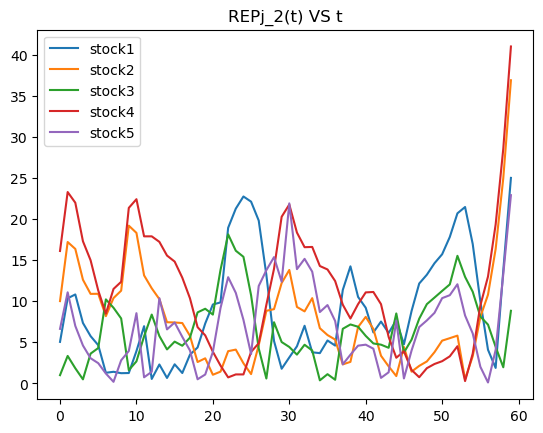

In [260]:
# Display these 5 curves REPj(t) versus t
plt.plot(REPj_2)
plt.title("REPj_2(t) VS t")  
plt.legend(['stock1', 'stock2','stock3','stock4','stock5'], loc='upper left')   

In [263]:
# Sort the array by columns
b2 = np.sort(REPj_2, axis=0)

In [284]:
# The 6 highest REPj_2(t) and the 6 lowest REPj_2(t)
high_REPj_2 = b2[-6:,:]
low_REPj_2 = b2[0:6,:]

high_REPj_2

array([[20.69, 16.36, 12.96, 21.76, 13.77],
       [21.26, 17.2 , 13.81, 21.98, 13.9 ],
       [21.46, 18.31, 15.4 , 22.41, 15.15],
       [22.11, 19.19, 15.52, 23.28, 15.36],
       [22.74, 24.98, 16.14, 28.55, 21.9 ],
       [25.  , 36.88, 18.13, 40.99, 22.9 ]], dtype=float32)

In [285]:
low_REPj_2

array([[0.54, 0.5 , 0.37, 0.28, 0.11],
       [0.66, 0.89, 0.44, 0.73, 0.19],
       [1.24, 1.05, 0.49, 0.75, 0.5 ],
       [1.26, 1.13, 0.59, 1.09, 0.6 ],
       [1.26, 1.43, 1.  , 1.09, 0.67],
       [1.29, 1.43, 1.12, 1.63, 0.74]], dtype=float32)

In [267]:
# Compute median medREPj = 60%REPj(t), for each stock Aj, j=1,2,3,4,5
# Calculate the index of the 60th percentile
med_REPj_2 = list()
for i in range(5):
    index = int(len(b2[:,i]) * 0.6)
    # Select the top 60% of values
    subset = b2[index,i]
    med_REPj_2.append(subset)
med_REPj_2


[9.6, 8.76, 7.44, 13.0, 7.73]

In [268]:
# Evaluate the ratios Sj(t)=REPj(t)/TRRj(t) for t=N-60,...,N-1 for each stock
Sj_2 = REPj_2[:59]/TRRj


/var/folders/qf/45vdh7_x3tn8ms40l6dgzrbh0000gn/T/ipykernel_40494/3856347766.py:2: RuntimeWarning: divide by zero encountered in divide
  Sj_2 = REPj_2[:59]/TRRj


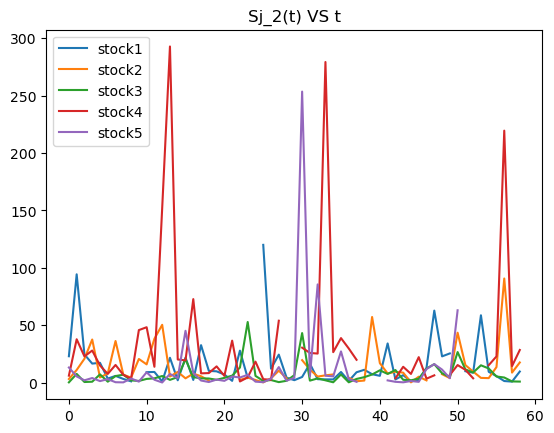

In [269]:
# Plot these 5 ratios versus t
plt.plot(Sj_2)
plt.title("Sj_2(t) VS t") 
plt.legend(['stock1', 'stock2','stock3','stock4','stock5'], loc='upper left')



In [270]:
# medSj_2 = median(all Sj_2(t))preferable to mean
# Sort the array by columns
bs_2 = np.sort(Sj_2, axis=0)
medSj_2= list()
for i in range(5):
    index = int(len(bs_2[:,i]) * 0.6)
    # Select the top 50% of values
    subset = bs_2[index,i]
    medSj_2.append(subset)
np.round(medSj_2,4)


array([10.2695,  9.633 ,  5.7641, 26.5608,  7.5518])

In [272]:
# CSP_2 FOR test set
predSIGN=np.sign(Z_2-Y_test)  # contains only 1 or -1
trueSIGN_list=[]  # contains 0,1,-1
for s in range(5):
    for i in range(59):
        TRR_SIGN=np.sign(Y_test[i+1,s]-Y_test[i,s])
        trueSIGN_list.append(TRR_SIGN)
trueSIGN=np.reshape(trueSIGN_list,(5,59)).T
sign_subtract=trueSIGN-predSIGN[0:59,:]  #subtraction 2 array, if result is 0, prediction correctly. 
unique,counts = np.unique(sign_subtract, return_counts=True) # counts[2]is the count of '0'
CSP_test=counts[2]/(59*5) # percentage of correct sign prediction on test set
CSP_test


0.4406779661016949

In [277]:
# Compare CSP_test for each stocks
for i in range(5):
    unique,counts= np.unique(sign_subtract[:,i], return_counts=True)
    CSP_test_stock=counts[unique==0]/59
    print('CSP_test_stock',i+1,CSP_test_stock)

CSP_test_stock 1 [0.28813559]
CSP_test_stock 2 [0.52542373]
CSP_test_stock 3 [0.49152542]
CSP_test_stock 4 [0.42372881]
CSP_test_stock 5 [0.47457627]


In [274]:
# Compare the REPj(t) between MLP* and MLP** for each stock
REPj=np.array(REPj)
REPj_2=np.array(REPj_2)
stock1_REP = np.stack([REPj[:,0],REPj_2[:,0]],axis=1)                      
stock2_REP = np.stack([REPj[:,1],REPj_2[:,1]],axis=1)
stock3_REP = np.stack([REPj[:,2],REPj_2[:,2]],axis=1)
stock4_REP = np.stack([REPj[:,3],REPj_2[:,3]],axis=1)
stock5_REP = np.stack([REPj[:,4],REPj_2[:,4]],axis=1)
stock1_REP.shape

(60, 2)

In [275]:
REPj[:,0].shape

(60,)

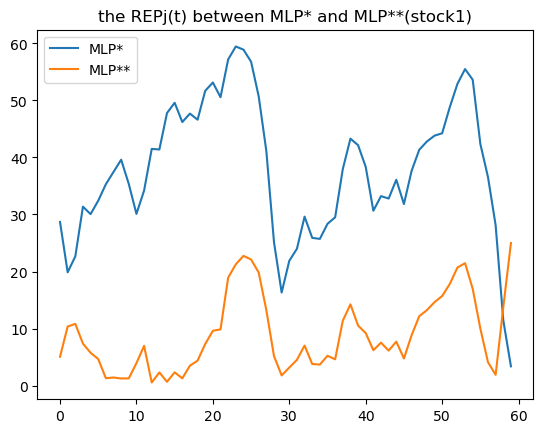

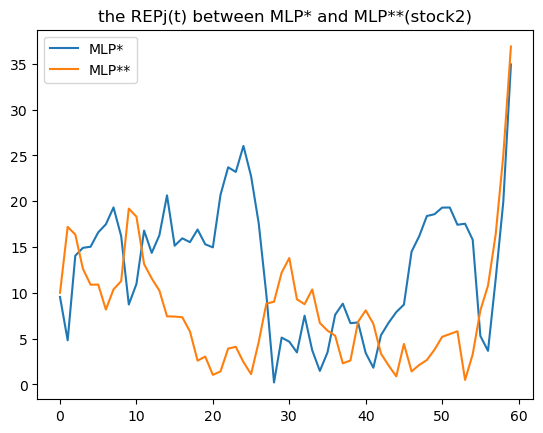

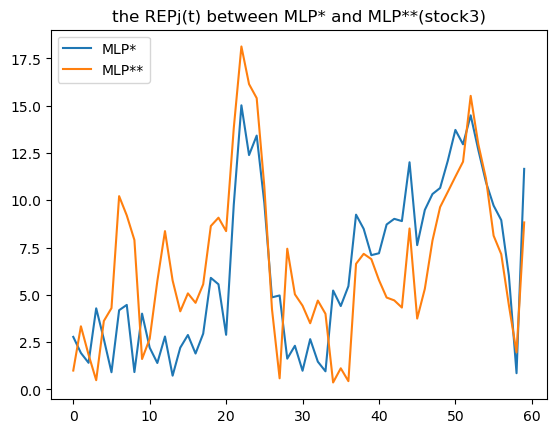

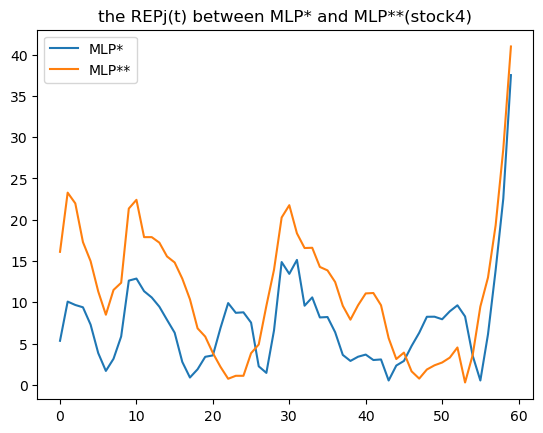

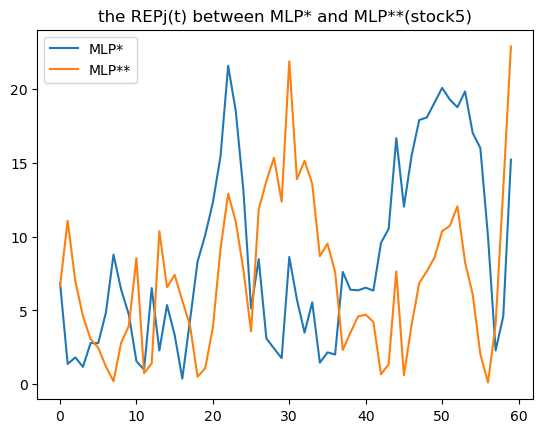

In [276]:
# Plot these 5 graphs to compare the REPj(t) between MLP* and MLP** for each stock
plt.plot(stock1_REP)
plt.title("the REPj(t) between MLP* and MLP**(stock1)") 
plt.legend(['MLP*', 'MLP**'], loc='upper left')
plt.show()

plt.plot(stock2_REP)
plt.title("the REPj(t) between MLP* and MLP**(stock2)") 
plt.legend(['MLP*', 'MLP**'], loc='upper left')
plt.show()

plt.plot(stock3_REP)
plt.title("the REPj(t) between MLP* and MLP**(stock3)") 
plt.legend(['MLP*', 'MLP**'], loc='upper left')
plt.show()

plt.plot(stock4_REP)
plt.title("the REPj(t) between MLP* and MLP**(stock4)") 
plt.legend(['MLP*', 'MLP**'], loc='upper left')
plt.show()

plt.plot(stock5_REP)
plt.title("the REPj(t) between MLP* and MLP**(stock5)") 
plt.legend(['MLP*', 'MLP**'], loc='upper left')
plt.show()